In [1]:
%matplotlib notebook

import torch
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

from torchvision.models import alexnet
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import DataLoader
from PytorchStorage import ForwardModuleStorage
from sklearn.cluster import KMeans
from tqdm import tqdm_notebook as tqdm
from collections import OrderedDict

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def pca(x, k=2):
    """
    From http://agnesmustar.com/2017/11/01/principal-component-analysis-pca-implemented-pytorch/
    """
    # preprocess the data
    X_mean = torch.mean(x,0)
    x = x - X_mean.expand_as(x)
    # svd
    U,S,V = torch.svd(torch.t(x))
    return torch.mm(x,U[:,:k])

## Model

In [4]:
model = alexnet(True).eval().to(device)

layer = model.features[11]

layer

ReLU(inplace)

In [5]:
# define a storage that will hold the data
storage = ForwardModuleStorage(model, [layer])

## Dataset

In [6]:
from torchvision.datasets import CIFAR10
tr = Compose([Resize((224,224)), ToTensor()])

ds = CIFAR10(root='~/Documents/datasets/', download=True, transform=tr)
dl = DataLoader(ds, num_workers=14, batch_size=128)


Files already downloaded and verified


In [7]:
def tensor2numpy(*args):
    return [e.cpu().numpy() for e in args]

In [10]:
class ModulePCA():
    """
    Apply and visualize PCA with k-features of a specific CNN-layer. 
    It computes the PCA values batch-wise to reduce memory usage and increase performance.
    """
    def __init__(self, module, layer, dataloader):
        self.module, self.layer = module, layer
        self.storage = ForwardModuleStorage(module, [layer])
        self.dataloader = dataloader
        self.ax2d = plt.subplot(111)
        
    def points(self, dataloader, k=2, n_batches=None):
        """
        Batch-wise PCA. It returns the pca points, the labels and the inputs as Pytorch Tensors.
        """
        for i, (x, y) in enumerate(dataloader):
            y, x = y.to(device), x.to(device)
            storage(x) # run input into the storage
            with torch.no_grad():
                features = storage[layer][0]
                flat_features = features.view(features.shape[0], -1)
                pca_features = pca(flat_features, k=k)
                del storage.state[layer] # reinit storage -> save memory
                storage.state[layer] = []
                if n_batches is not None and i == n_batches: break
                yield pca_features, y, x
    
    def __call__(self, *args, **kwargs):
        for data in tqdm(self.points(self.dataloader, *args, **kwargs)):
            pca_points, y, x = tensor2numpy(*data)
            for i, label in enumerate(np.unique(y).tolist()):
                self.ax2d.scatter(pca_points[y == i, 0], pca_points[y == i, 1], label=label)
        return self
    
    def plot2d(self):
        fig = plt.figure()
        handles, labels = self.ax2d.get_legend_handles_labels()
        by_label = OrderedDict(zip(labels, handles))
        self.ax2d.legend(by_label.values(), by_label.keys())
        return fig

<IPython.core.display.Javascript object>


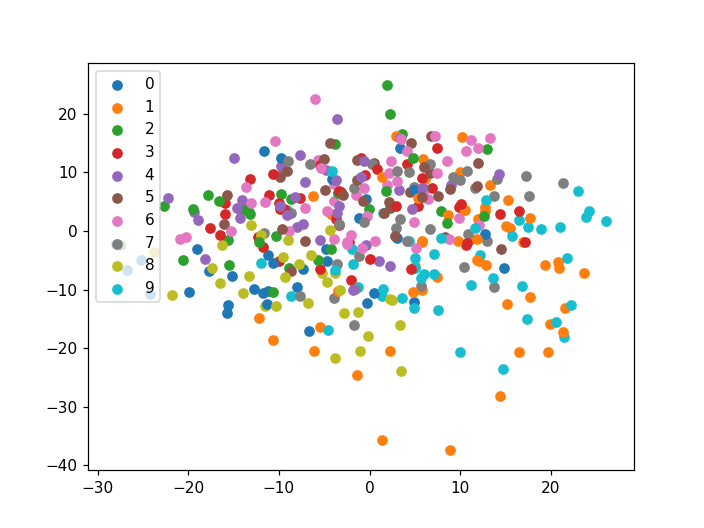

<IPython.core.display.Javascript object>


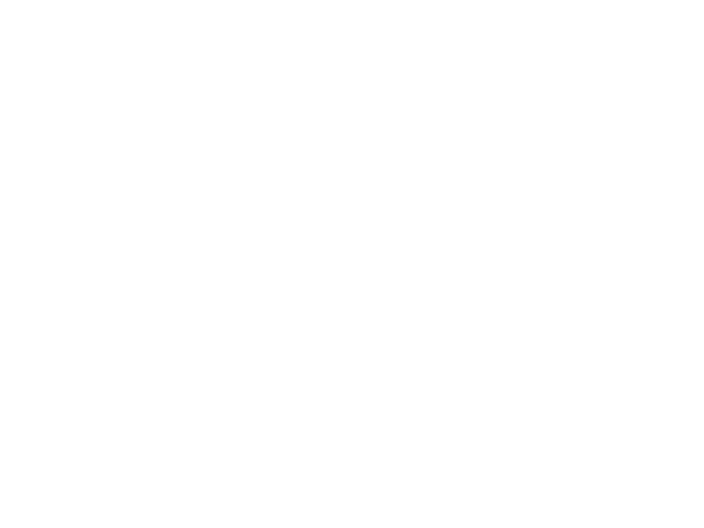

In [9]:
module_pca = ModulePCA(model,  model.features[11], dl)
module_pca(k=2, n_batches=3).plot2d().show()